In [197]:
import numpy as np
import matplotlib.pyplot as plt

n_runs = 2 # Number of runs to average over

# Constants
k = 1.380649e-23 # Boltzmann constant (J/K)
T = 300 # Temperature (K)
kT = 1.0 # Product of Boltzmann constant and temperature (J)
epsilon = 1.0  # Depth of potential well
sigma = 1.0  # Finite distance where potential is zero
num_molecules = 20  # Number of molecules
max_displacement = 0.01  # Maximum displacement in a single step
num_steps = 500  # Number of steps for the simulation
densities = np.linspace(0.1, 0.8, 10)  # Different densities to simulate
pressures = []  # Store the average pressure for each density

def total_potential_energy(positions, box_size):
    # Compute all pairwise distances using broadcasting
    diff = positions[:, np.newaxis, :] - positions[np.newaxis, :, :]
    diff = diff - np.round(diff / box_size) * box_size  # Periodic boundary conditions
    distances = np.sqrt(np.sum(diff**2, axis=-1))
    np.fill_diagonal(distances, np.inf)

    # Vectorized Lennard-Jones potential calculation
    r6 = (sigma / distances)**6
    r12 = r6**2
    return np.sum(4 * epsilon * (r12 - r6)) / 2  # Divide by 2 to correct for double counting

def metropolis_step(positions, box_size):
    total_energy = total_potential_energy(positions, box_size)

    # Choose a random molecule
    molecule_idx = np.random.randint(num_molecules)
    old_position = positions[molecule_idx].copy()

    # Move the molecule to a new position
    displacement = (np.random.rand(2) - 0.5) * max_displacement
    positions[molecule_idx] += displacement

    # Apply periodic boundary conditions
    positions[molecule_idx] %= box_size

    # Calculate the energy change
    new_energy = total_potential_energy(positions, box_size)
    delta_energy = new_energy - total_energy

    # Metropolis criterion
    if delta_energy > 0 and np.exp(-delta_energy / kT) < np.random.rand():
        # Reject the move, revert to the old position
        positions[molecule_idx] = old_position
    else:
        # Accept the move, update total energy
        total_energy = new_energy

    return positions, total_energy

def calculate_pressure(positions, box_size):
    """ Calculate pressure using the virial theorem """
    diff = positions[:, np.newaxis, :] - positions[np.newaxis, :, :]
    diff = diff - np.round(diff / box_size) * box_size
    distances = np.sqrt(np.sum(diff**2, axis=-1))
    np.fill_diagonal(distances, np.inf)
    forces = lennard_jones_force(distances)
    forces = np.triu(forces, 1)
    distances = np.triu(distances, 1)
    virial = np.sum(forces*distances) / 3
    beta = 1 / kT
    density = num_molecules / box_size**2
    volume = box_size**2
    pressure = density / beta + virial / volume
    return pressure

def lennard_jones_force(distances):
    """ Calculate Lennard-Jones force for a distance array """
    return 48 * epsilon * (sigma**12 / distances**13 - 0.5 * sigma**6 / distances**7)

In [198]:
# Main simulation
np.random.seed(0)
for density in densities:
    box_size = np.sqrt(num_molecules / density)
    positions = np.random.rand(num_molecules, 2) * box_size

    # Initial total energy
    total_energy = total_potential_energy(positions, box_size)

    pressures_for_density = []
    for step in range(num_steps):
        positions, total_energy = metropolis_step(positions, box_size)
        if step > num_steps // 2:  # Collect data after reaching equilibrium
            pressure = calculate_pressure(positions, box_size)
            pressures_for_density.append(pressure)

    avg_pressure = np.mean(pressures_for_density)
    pressures.append(avg_pressure)

225.1969786271932 200.00000000000003 0.09999999999999999 1.0
225.2001794365195 200.00000000000003 0.09999999999999999 1.0
225.20012046878142 200.00000000000003 0.09999999999999999 1.0
225.21704649048036 200.00000000000003 0.09999999999999999 1.0
225.21705093779687 200.00000000000003 0.09999999999999999 1.0
225.21703965610357 200.00000000000003 0.09999999999999999 1.0
225.21703965610357 200.00000000000003 0.09999999999999999 1.0
225.2200007518064 200.00000000000003 0.09999999999999999 1.0
225.21436606589066 200.00000000000003 0.09999999999999999 1.0
211.01472993100322 200.00000000000003 0.09999999999999999 1.0
211.01461537753445 200.00000000000003 0.09999999999999999 1.0
211.01376007725193 200.00000000000003 0.09999999999999999 1.0
211.01376007725193 200.00000000000003 0.09999999999999999 1.0
211.14081229089115 200.00000000000003 0.09999999999999999 1.0
203.056975488024 200.00000000000003 0.09999999999999999 1.0
203.056975488024 200.00000000000003 0.09999999999999999 1.0
203.05833547484

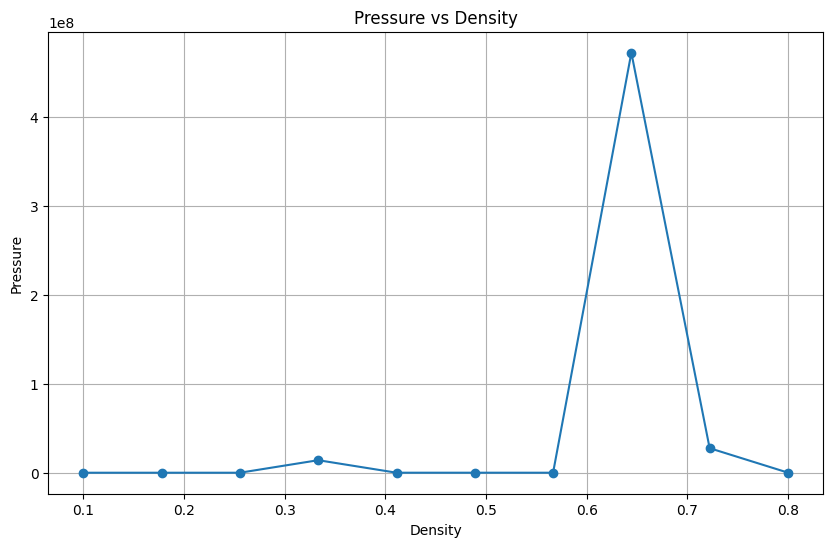

In [199]:
# Plotting Density vs Pressure
plt.figure(figsize=(10, 6))
plt.plot(densities, pressures, marker='o', linestyle='-')
plt.title("Pressure vs Density")
plt.xlabel("Density")
plt.ylabel("Pressure")
plt.grid(True)
plt.show()